# 発表資料などの資料作成に必要な素材を生成するためのノート


In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

                                                          1          2    \
Name                                                                       
.TAU_application, ALLOC_SPACE, CG, INITIALIZE_M...        1.0        1.0   
CONJ_GRAD                                                76.0       76.0   
ICNVRT                                              1984770.0  2263540.0   
MPI_Irecv(), MPI_Send(), MPI_Wait()                   12236.0    12483.0   
SPRNVC, VECSET                                        84375.0    93750.0   

                                                          4          8    \
Name                                                                       
.TAU_application, ALLOC_SPACE, CG, INITIALIZE_M...        1.0        1.0   
CONJ_GRAD                                                76.0       76.0   
ICNVRT                                              2821070.0  3936140.0   
MPI_Irecv(), MPI_Send(), MPI_Wait()                   10982.0    13984.0   
SPRNVC, VEC

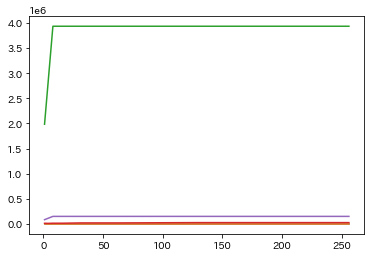

In [2]:
summarized_ = return_summarized_Fixed_dataframe()
print(summarized_)
indices = summarized_.index.values
columns = summarized_.columns.values
print(indices)
print(columns)

plt.figure()
for row in indices:
    print(summarized_.loc[row].to_numpy())
    plt.plot(columns, summarized_.loc[row].to_numpy())

In [3]:
return_summarized_Fixed_dataframe(BenchMark_name="cg").to_csv("./tmp_GenerateResources/SummarizedFixedDataframe_cg.csv")

In [6]:
def generateScoreTable(benchmark_name="cg"):
    list_ScoreTable = []
    dict_summary_fixed_class = return_dict_summary_fixed(benchmark_name=benchmark_name, fixed="class")
    raw_x = dict_summary_fixed_class["processes"]
#     print(f"raw_x : {raw_x}, benchmark : {benchmark_name}")
    for content in dict_summary_fixed_class:
        if(content == "processes"):
            continue
        raw_y = dict_summary_fixed_class[content]
        if(does_include_nan(raw_y)):
            continue
#         print(f"raw_y(={content}) : {raw_y}")
        # 線形モデル
        model_lin = ModelLin(raw_x, raw_y, benchmark_name, content)
        model_lin.calc_lr()
        model_lin.calc_r2_score()
        model_lin.calc_mae_score()
        model_lin.calc_mse_score()
        model_lin.calc_rmse_score()
        model_lin.calc_mape_score()
        model_lin.plot_graph()
        plt.title(f"ベンチマーク名：{model_lin.benchmark_name}, 関数名：{model_lin.function_name}, MAPE : {model_lin.mape_score}", y=-0.2)
        plt.show()
        # logモデル
        model_log10 = ModelLog10(raw_x, raw_y, benchmark_name, content)
        model_log10.calc_lr()
        model_log10.calc_r2_score()
        model_log10.calc_mae_score()
        model_log10.calc_mse_score()
        model_log10.calc_rmse_score()
        model_log10.calc_mape_score()
        model_log10.plot_graph()
        plt.title(f"ベンチマーク名：{model_log10.benchmark_name}, 関数名：{model_log10.function_name}, MAPE : {model_log10.mape_score}", y=-0.2)
        plt.show()
        # 反比例モデル
        model_ip = ModelIP(raw_x, raw_y, benchmark_name, content)
        model_ip.calc_lr()
        model_ip.calc_r2_score()
        model_ip.calc_mae_score()
        model_ip.calc_mse_score()
        model_ip.calc_rmse_score()
        model_ip.calc_mape_score()
        model_ip.plot_graph()
        plt.title(f"ベンチマーク名：{model_ip.benchmark_name}, 関数名：{model_ip.function_name}, MAPE : {model_ip.mape_score}", y=-0.2)
        plt.show()
        list_ScoreTable.append([content, model_lin.mape_score, model_log10.mape_score, model_ip.mape_score])
    df_ScoreTable = pd.DataFrame(list_ScoreTable)
    df_ScoreTable.columns = ["", "x mape", "logx mape", "1/x mape"]
    df_ScoreTable.set_index("",inplace=True)
    df_ScoreTable

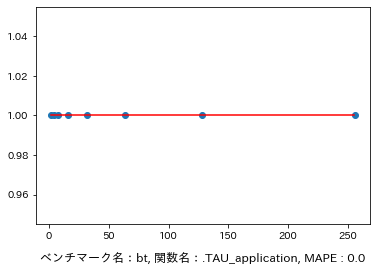

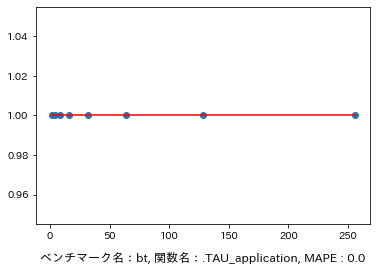

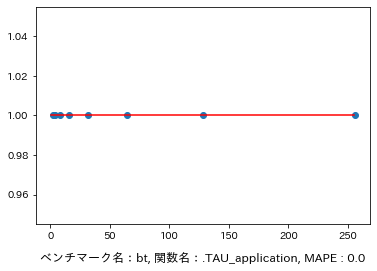

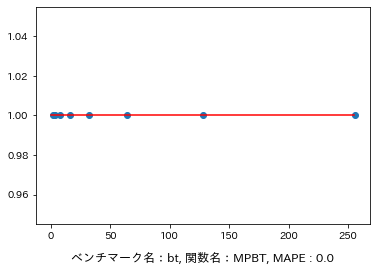

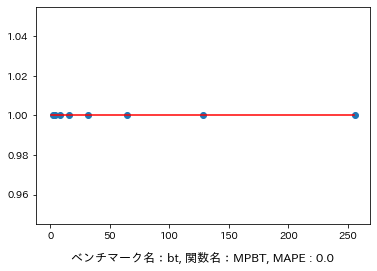

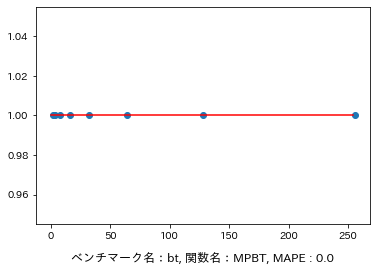

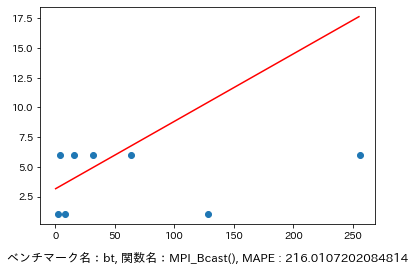

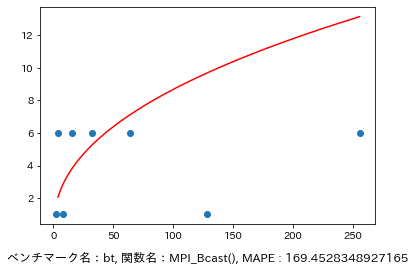

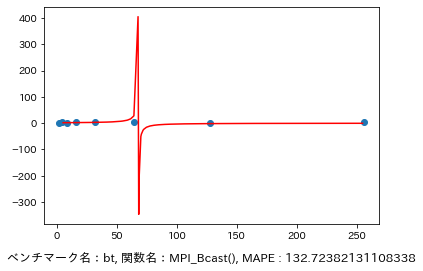

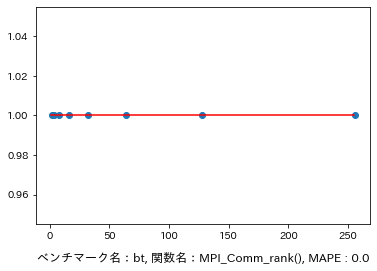

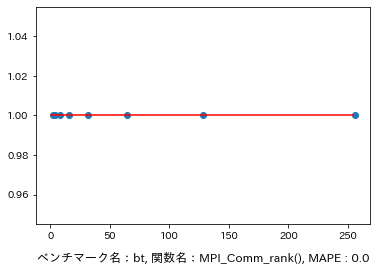

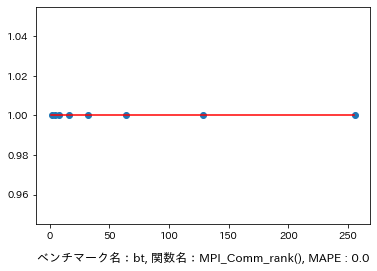

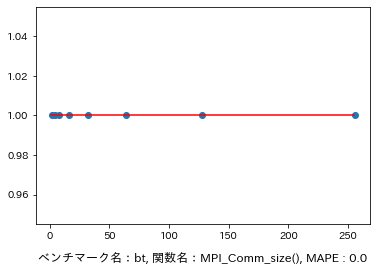

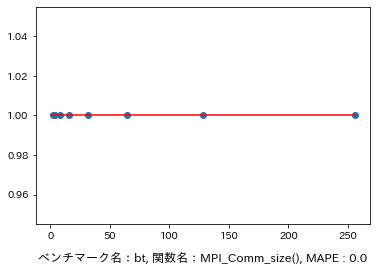

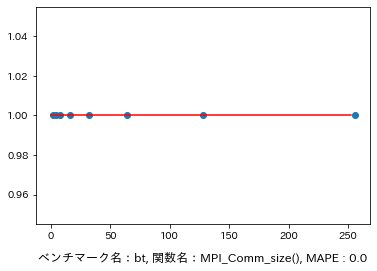

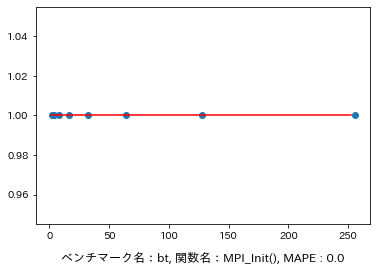

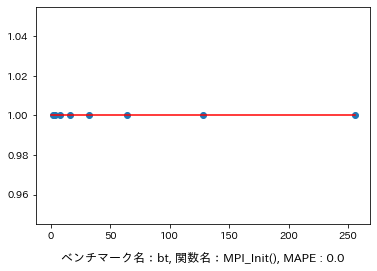

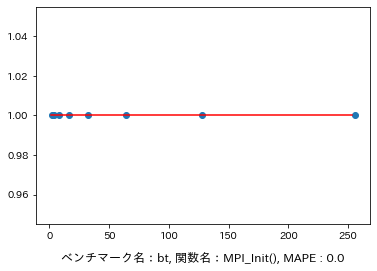

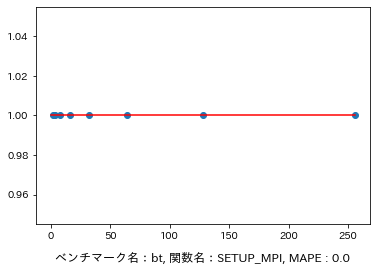

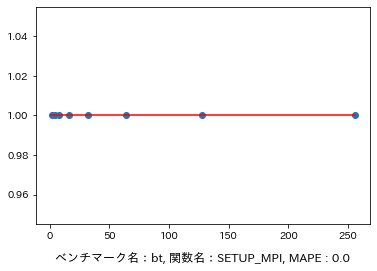

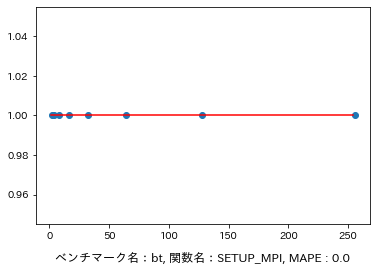

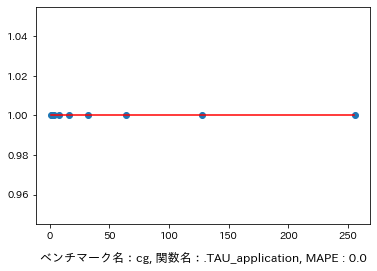

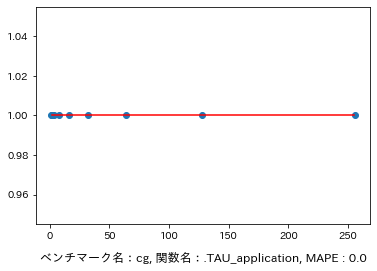

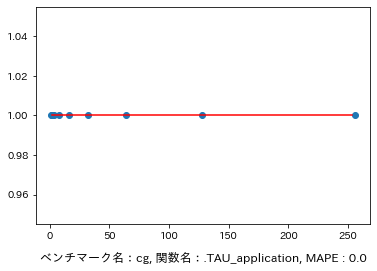

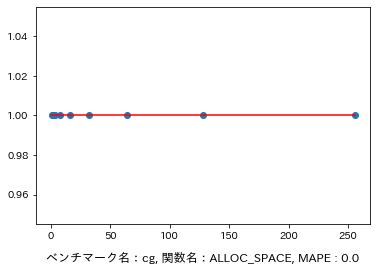

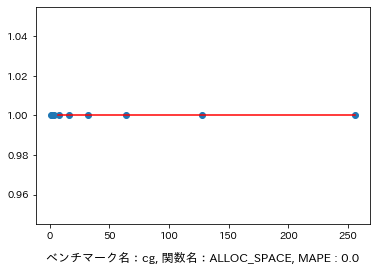

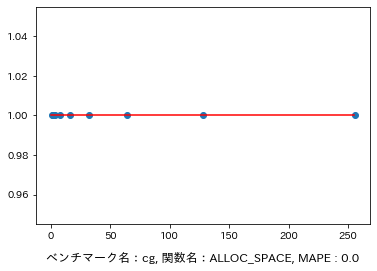

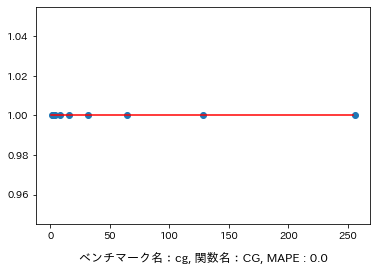

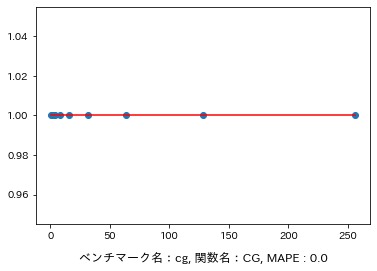

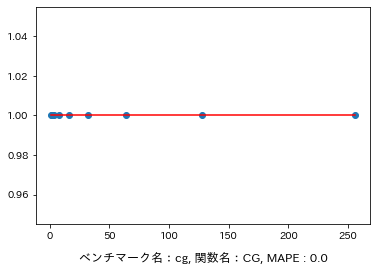

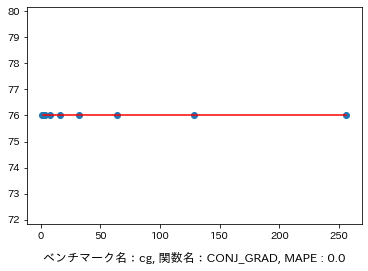

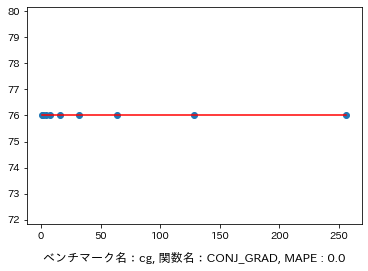

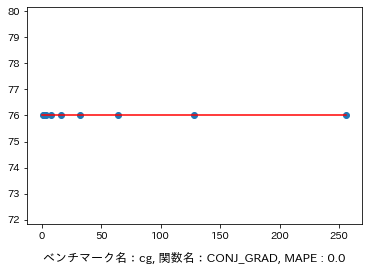

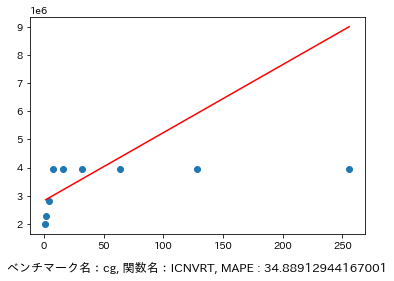

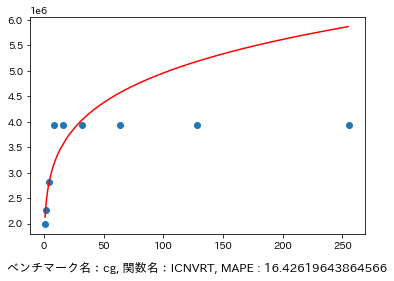

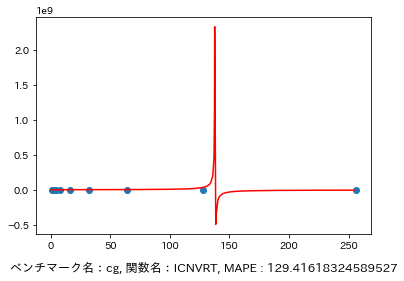

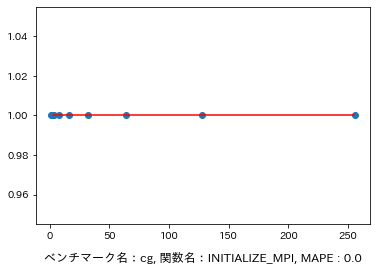

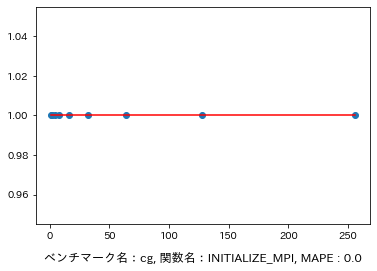

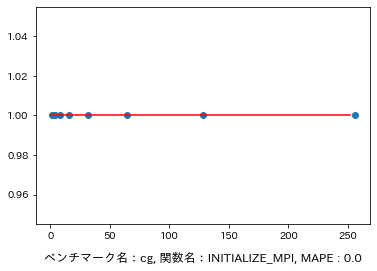

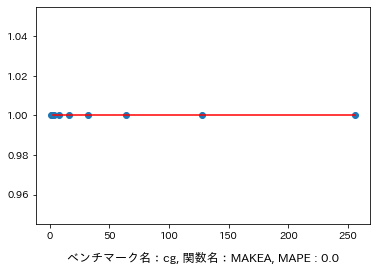

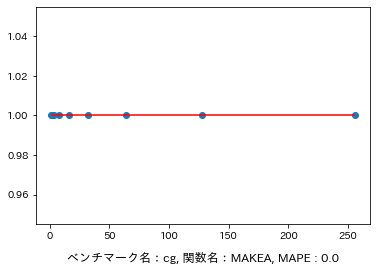

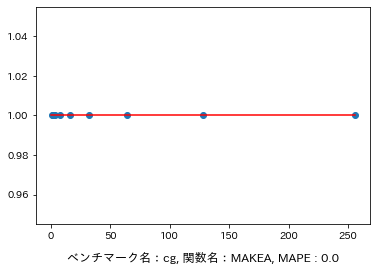

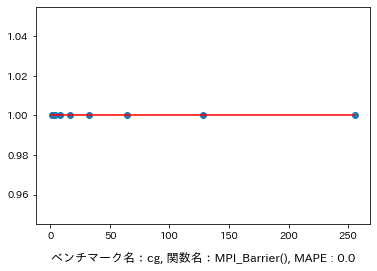

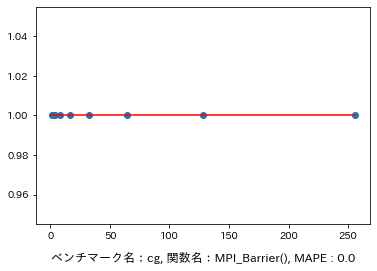

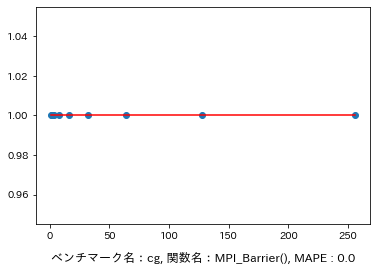

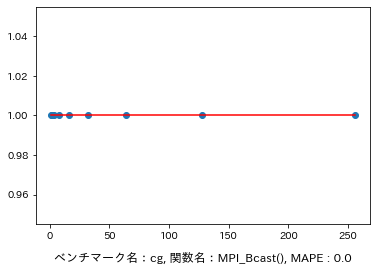

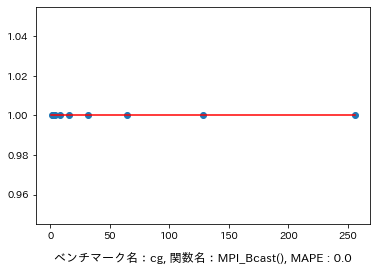

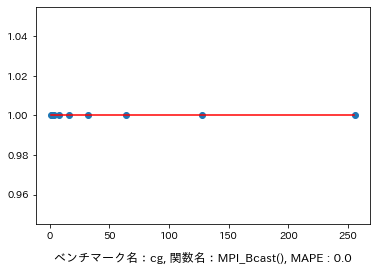

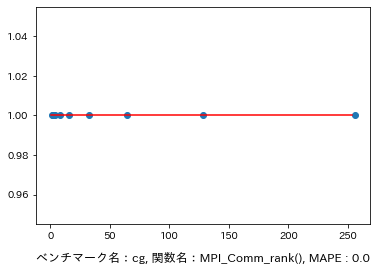

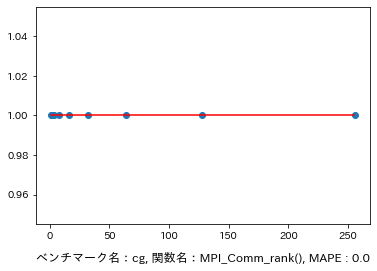

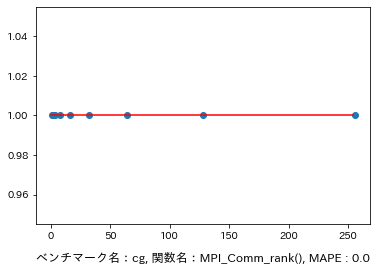

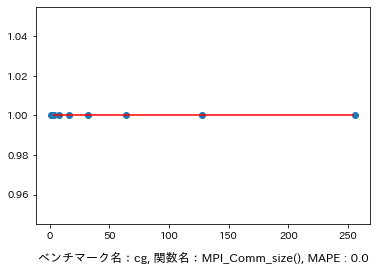

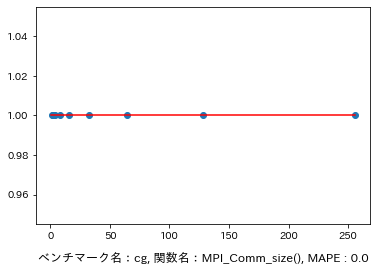

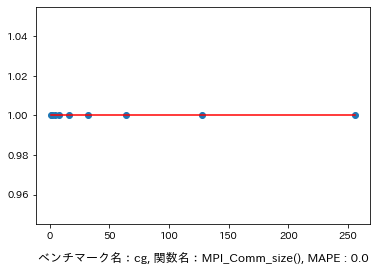

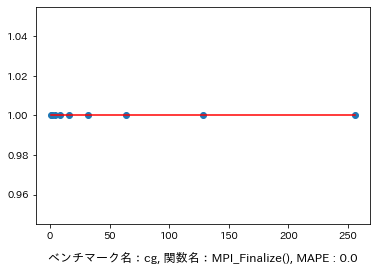

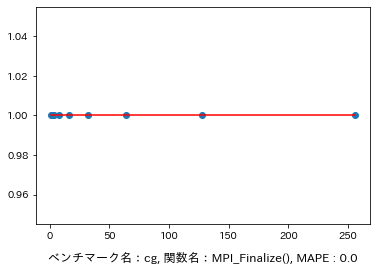

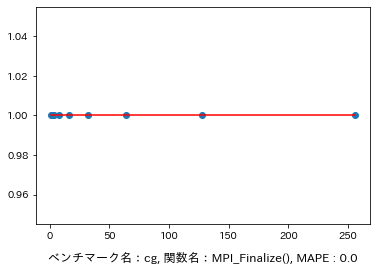

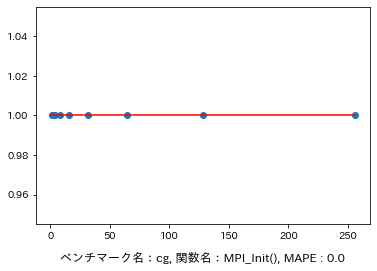

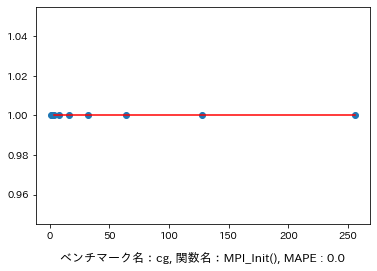

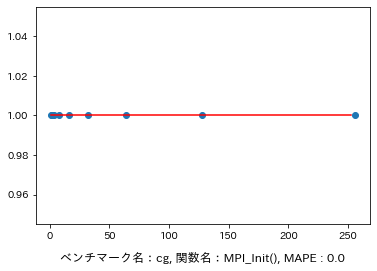

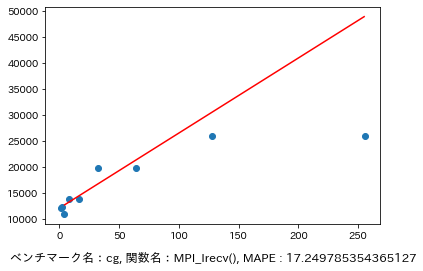

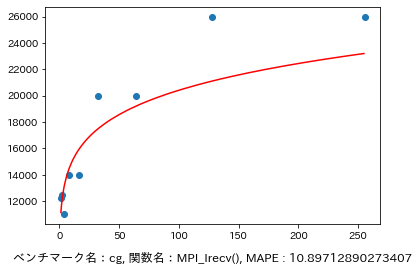

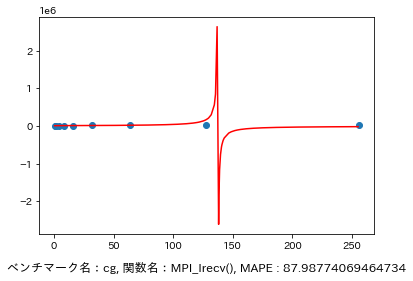

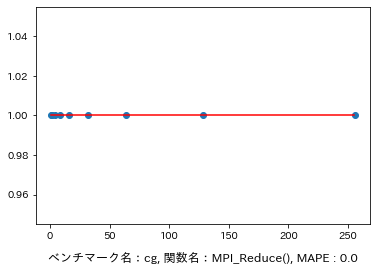

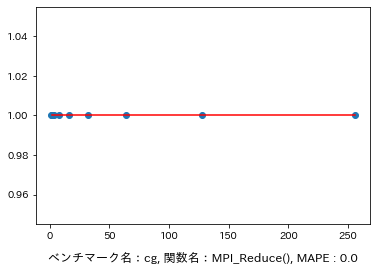

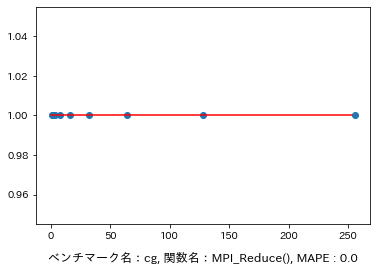

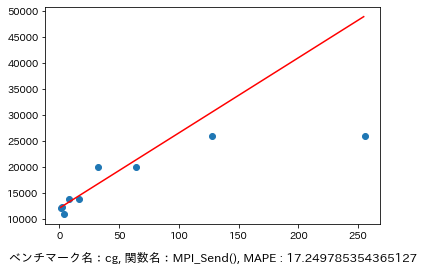

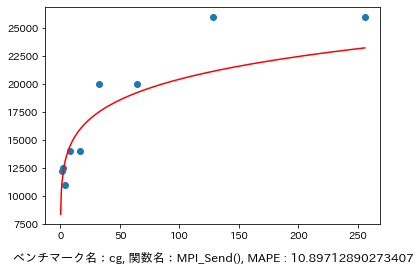

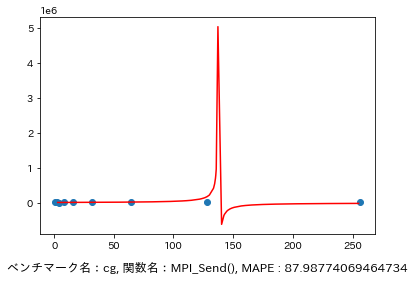

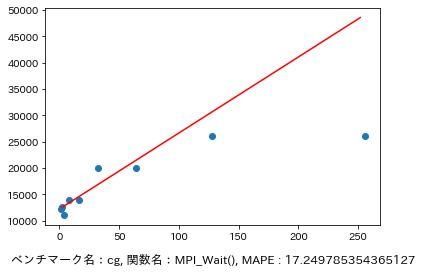

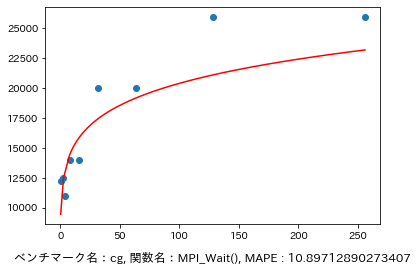

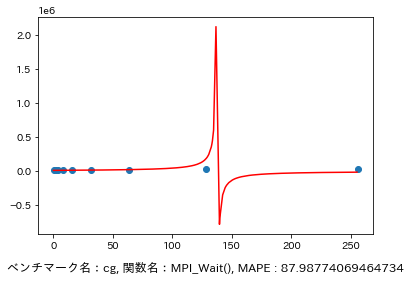

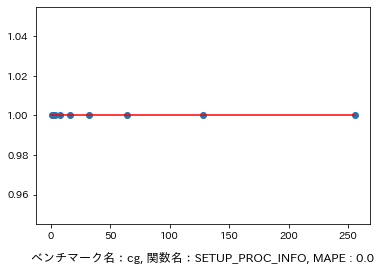

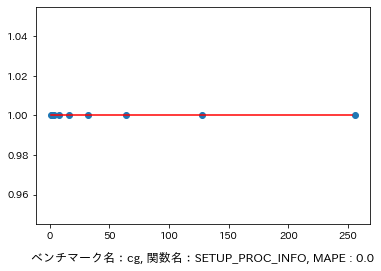

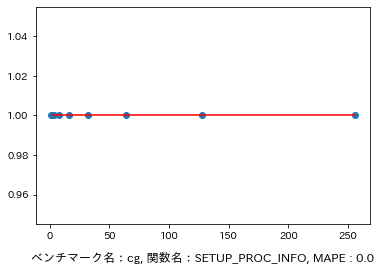

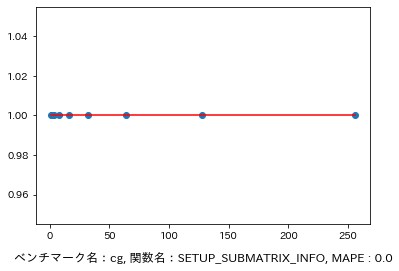

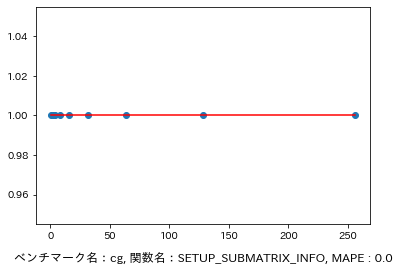

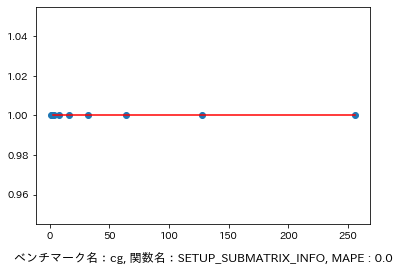

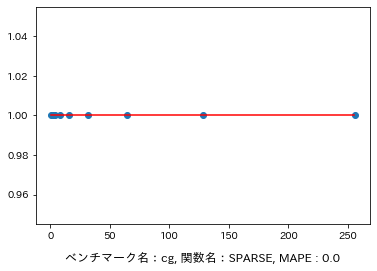

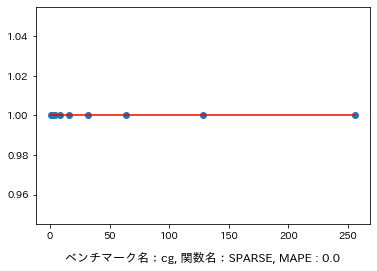

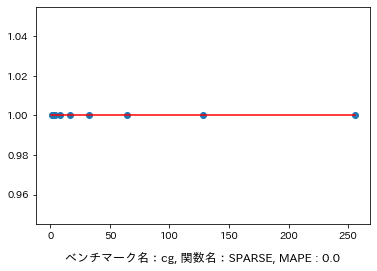

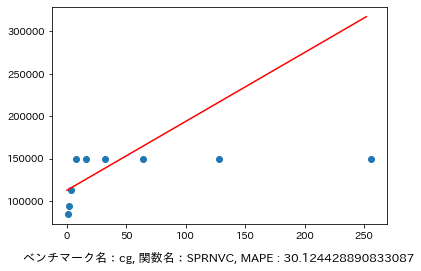

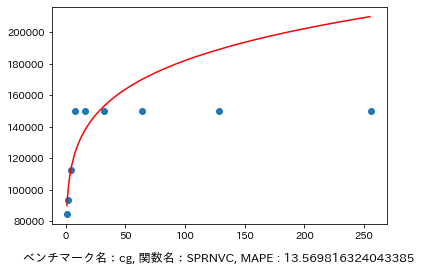

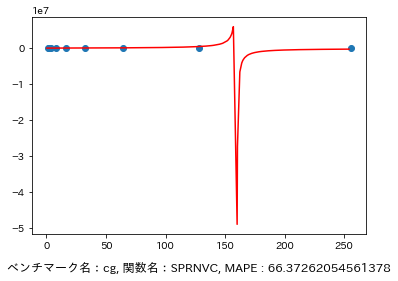

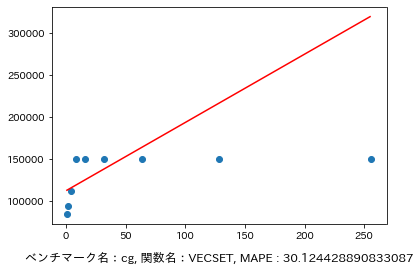

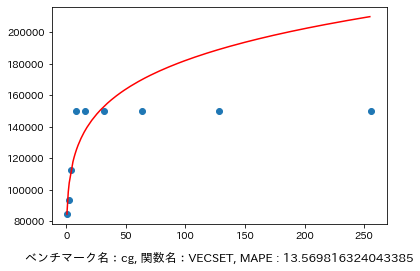

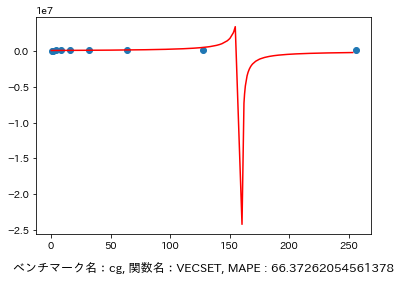

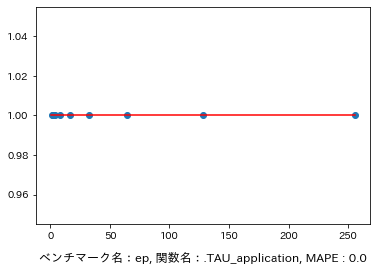

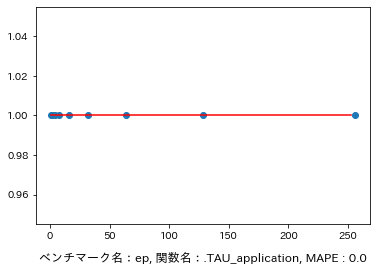

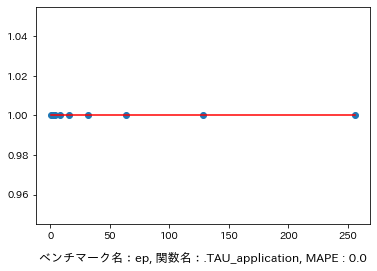

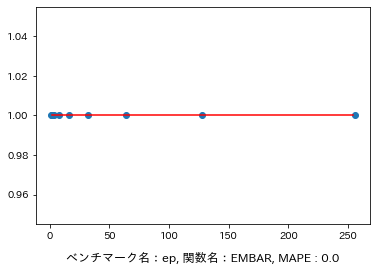

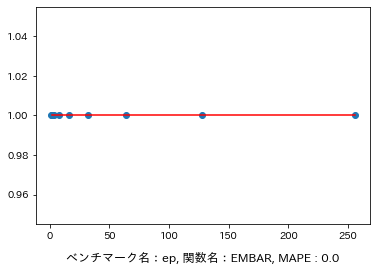

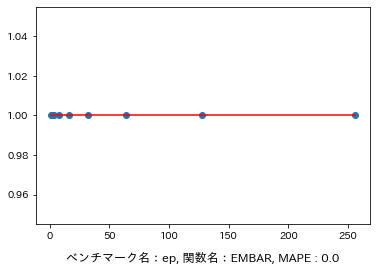

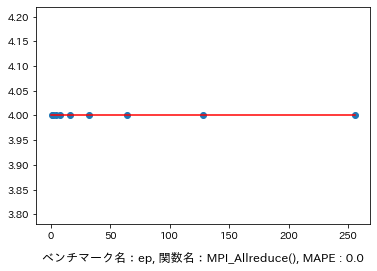

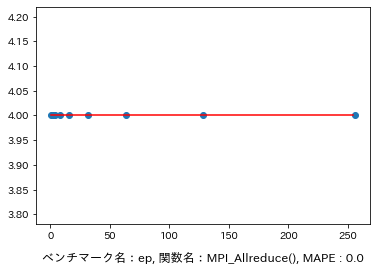

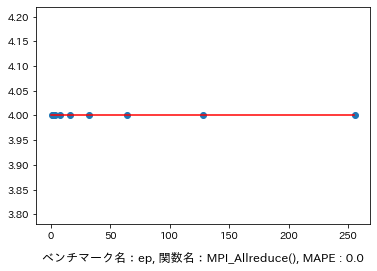

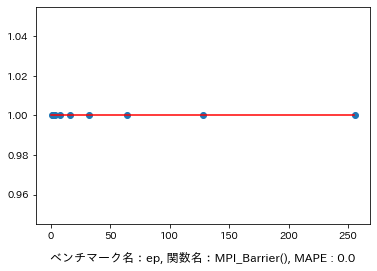

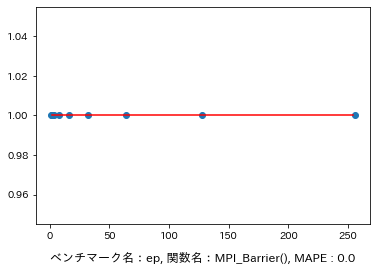

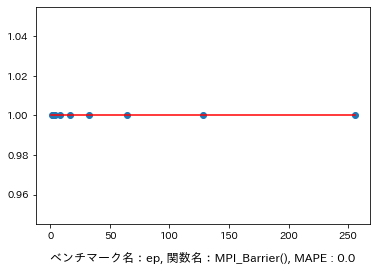

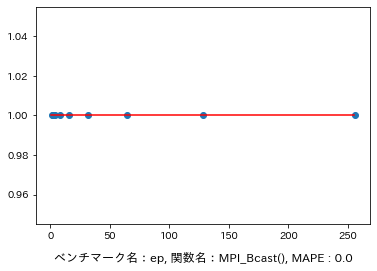

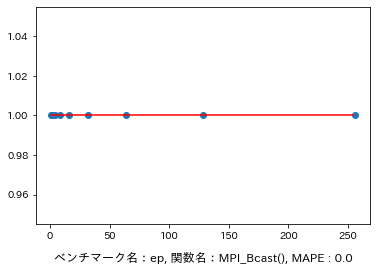

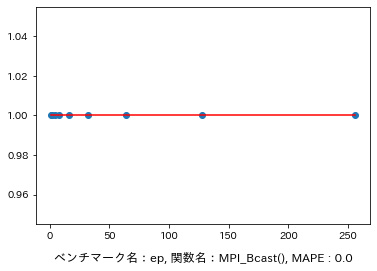

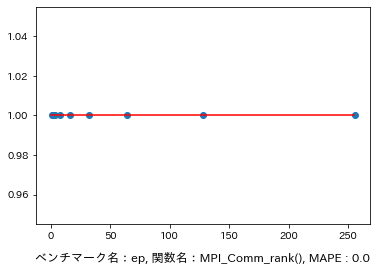

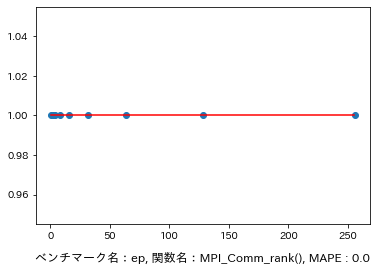

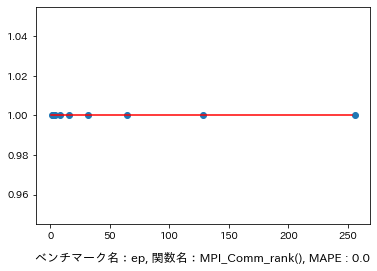

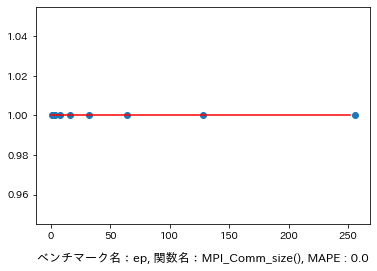

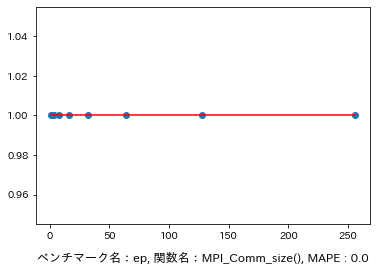

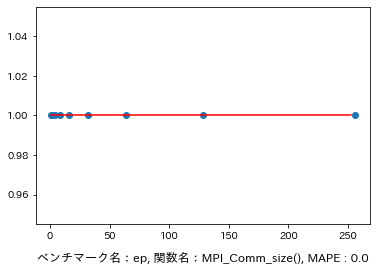

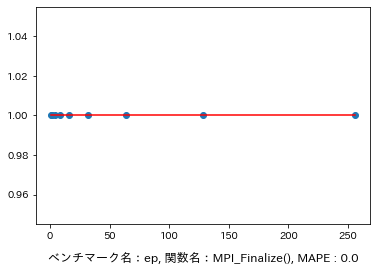

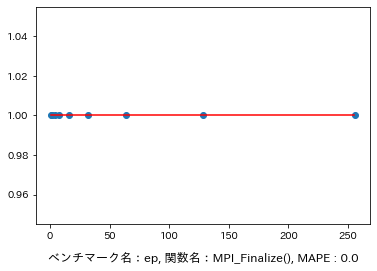

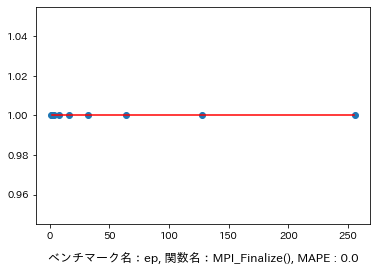

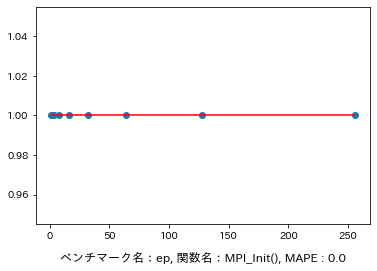

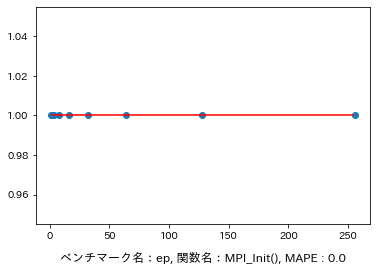

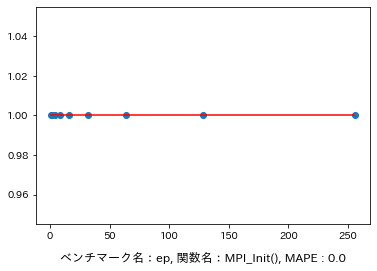

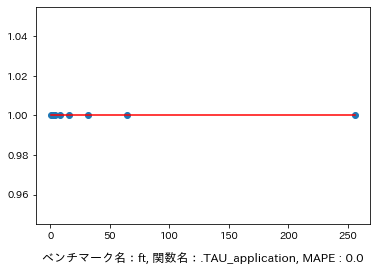

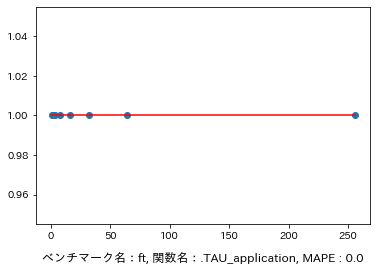

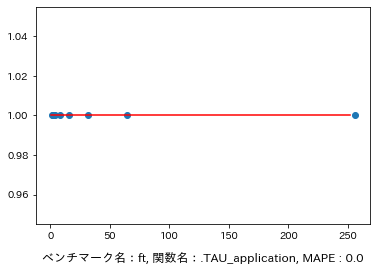

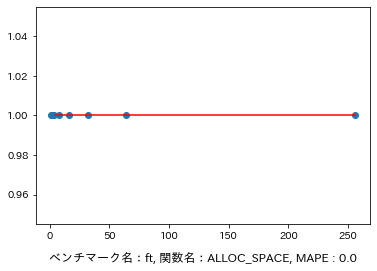

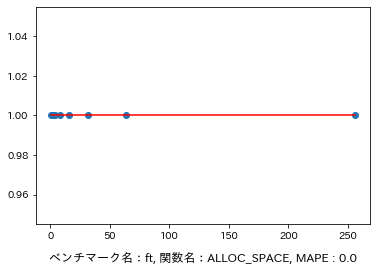

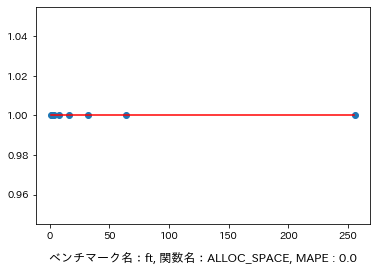

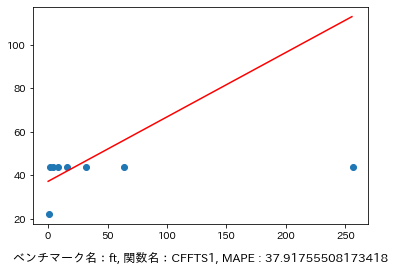

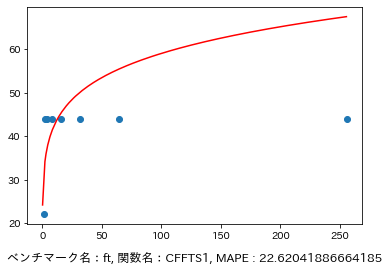

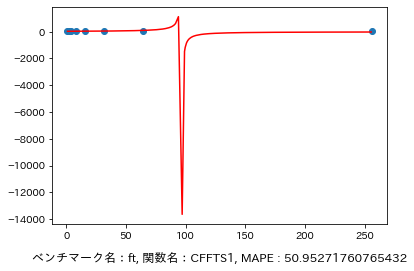

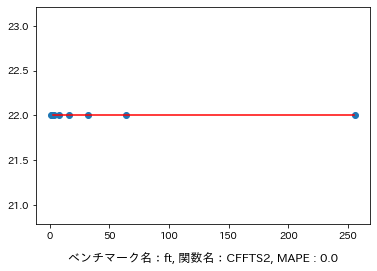

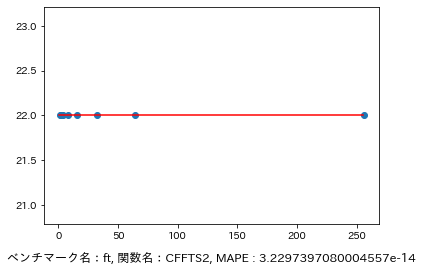

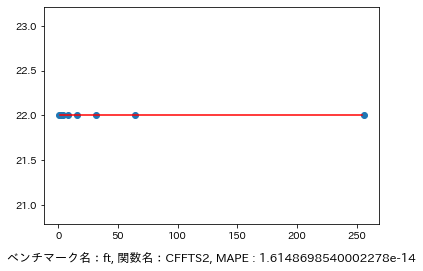

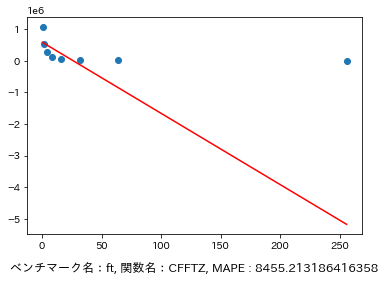

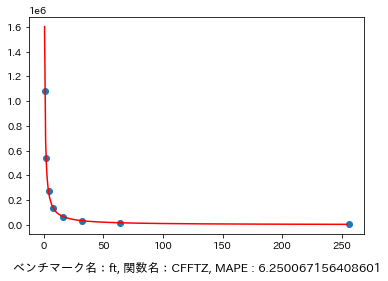

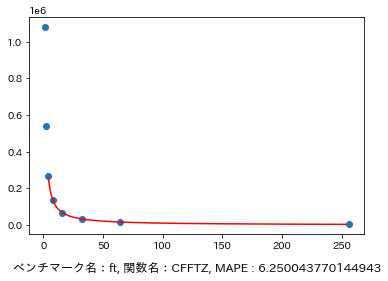

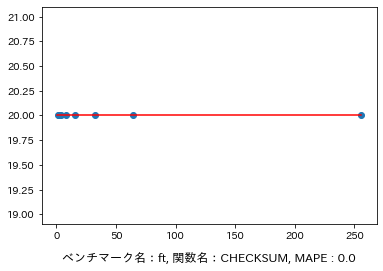

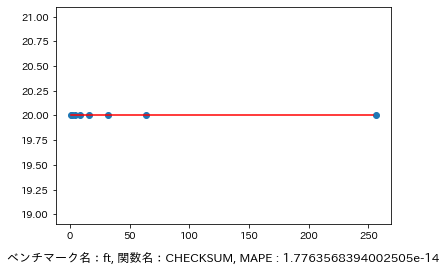

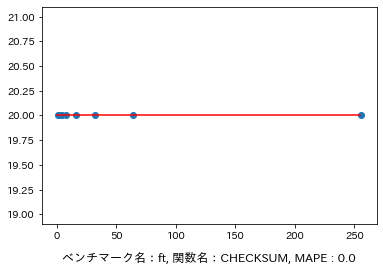

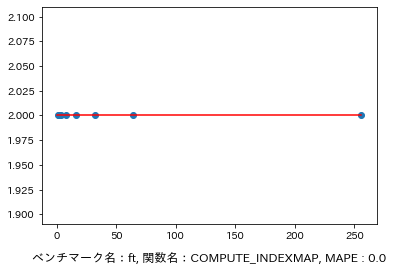

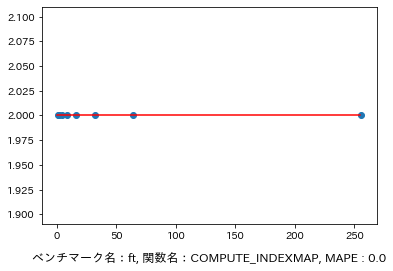

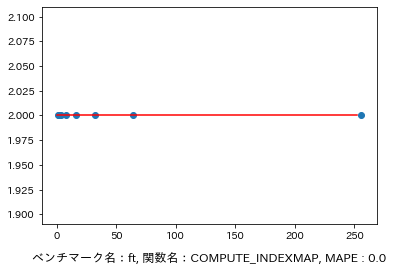

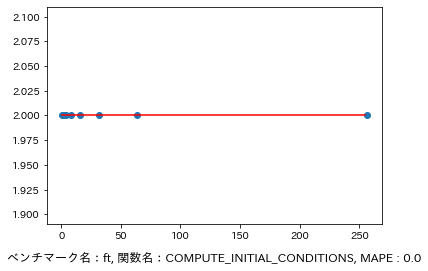

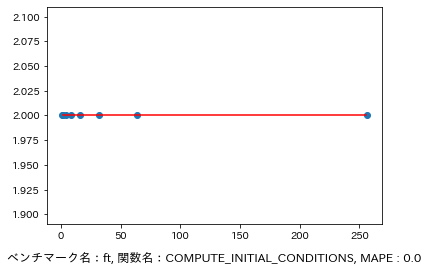

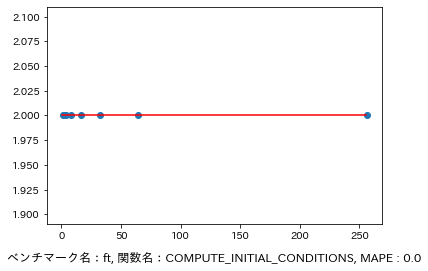

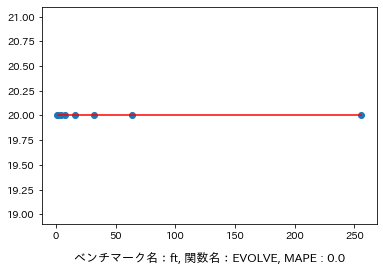

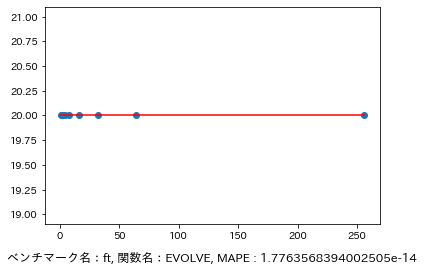

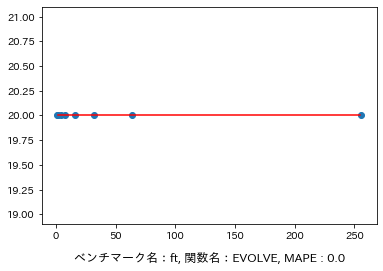

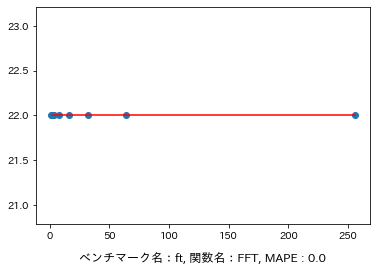

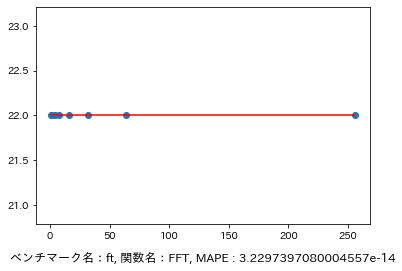

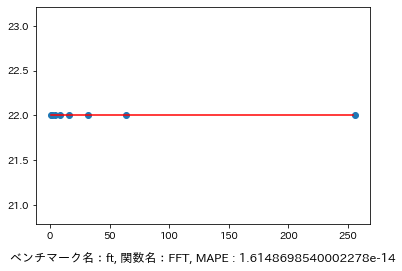

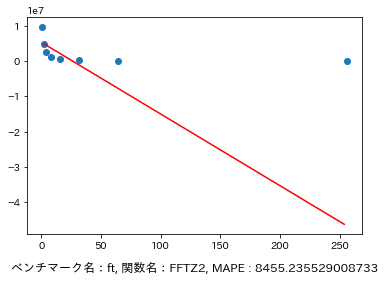

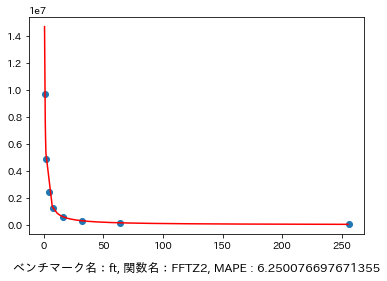

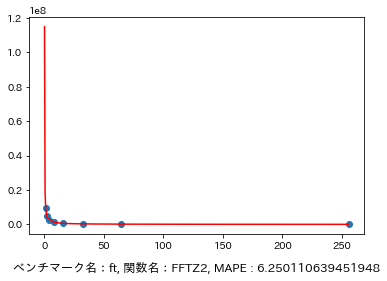

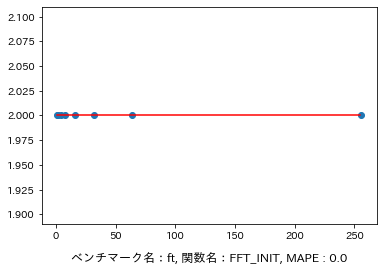

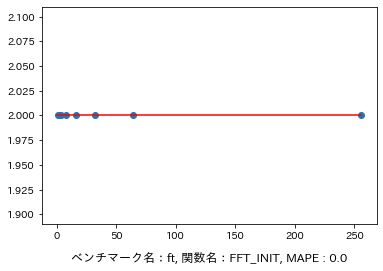

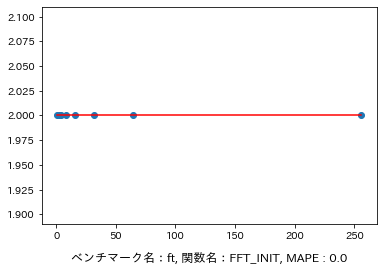

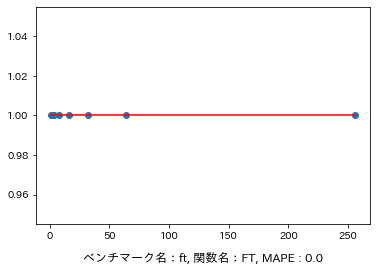

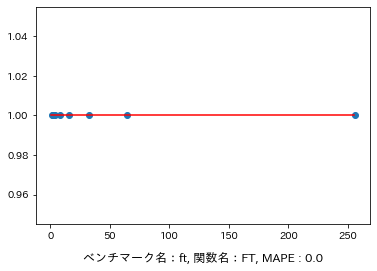

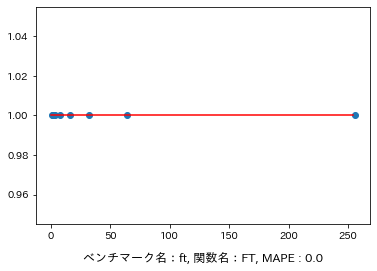

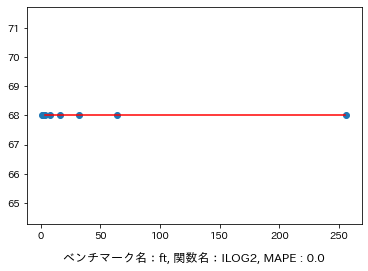

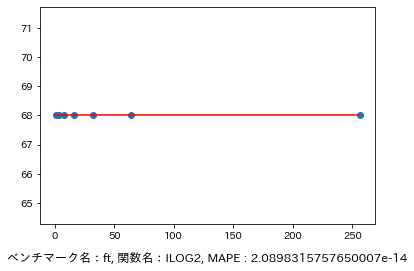

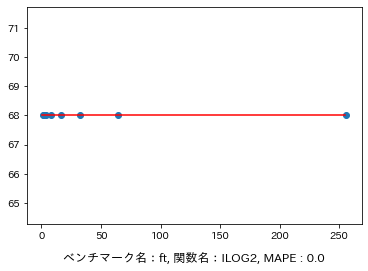

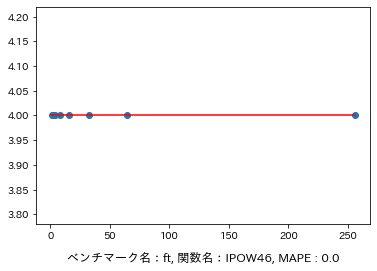

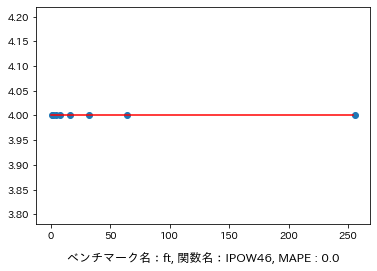

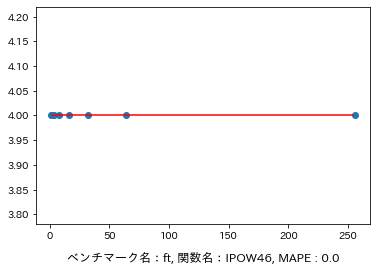

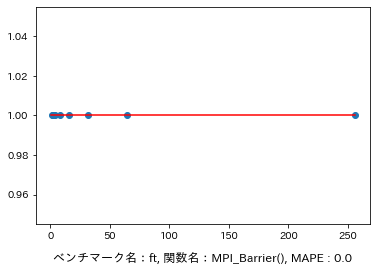

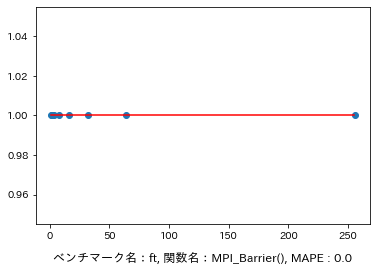

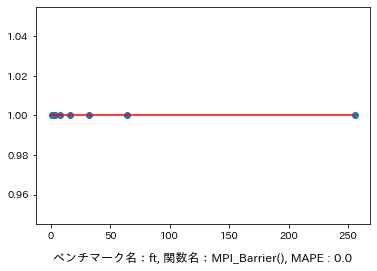

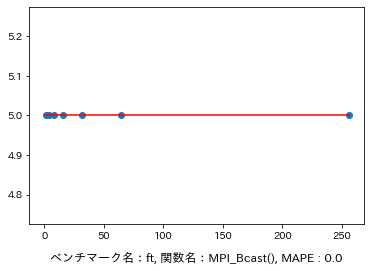

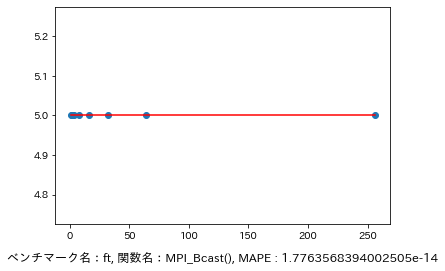

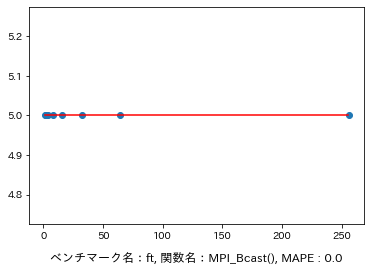

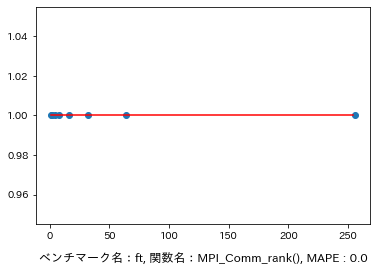

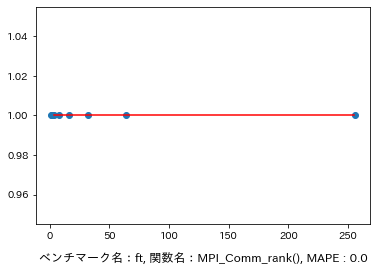

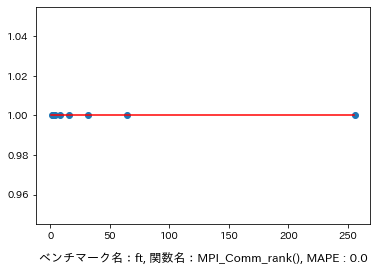

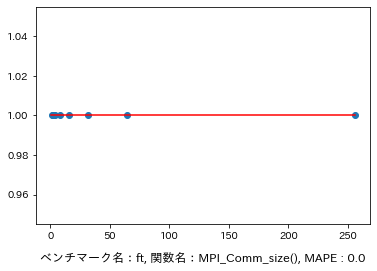

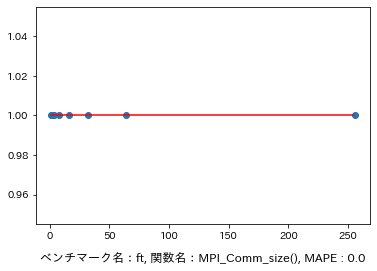

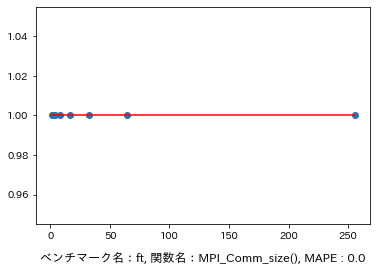

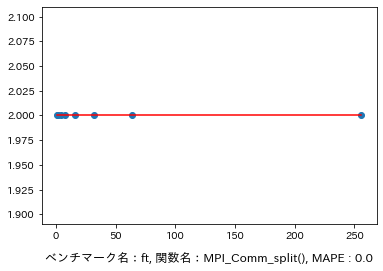

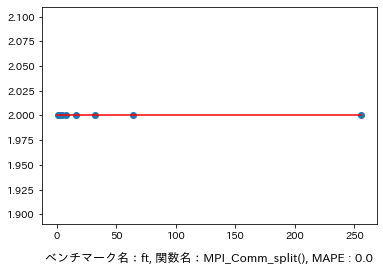

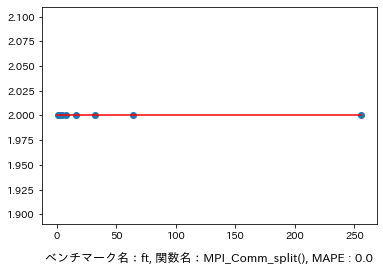

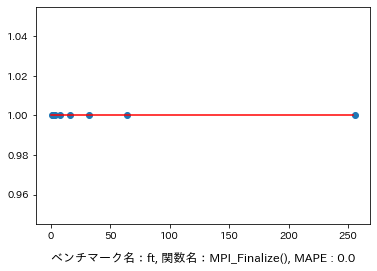

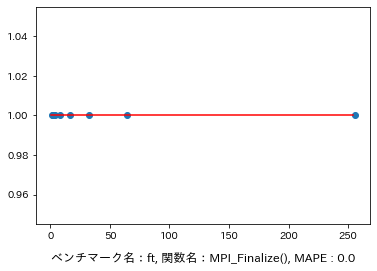

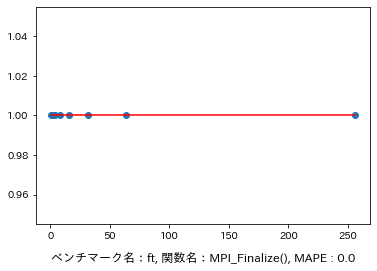

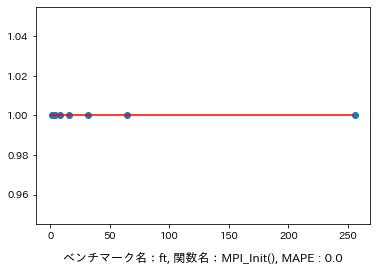

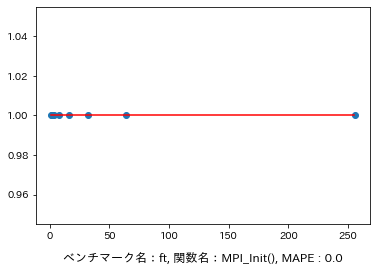

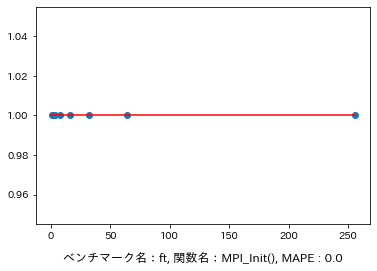

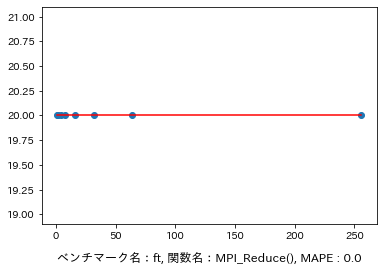

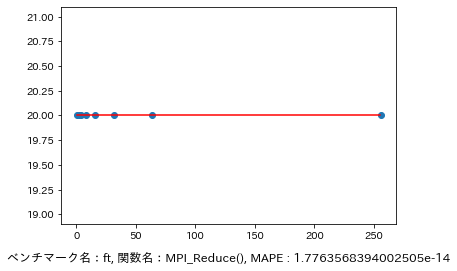

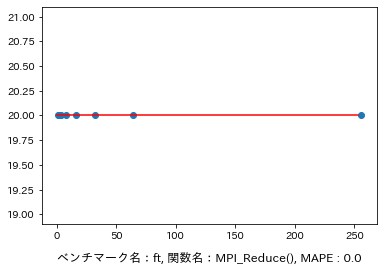

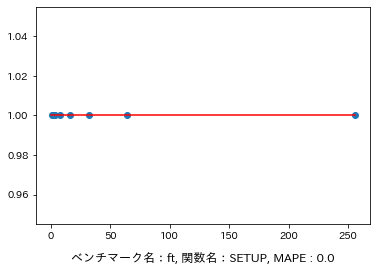

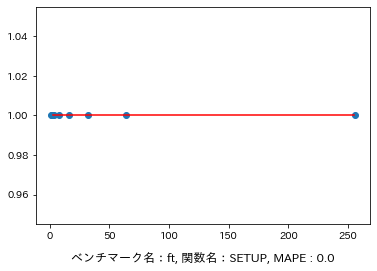

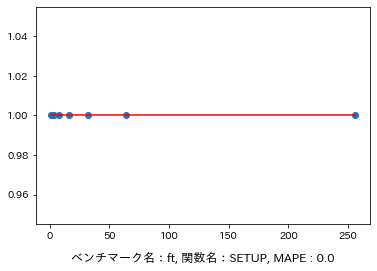

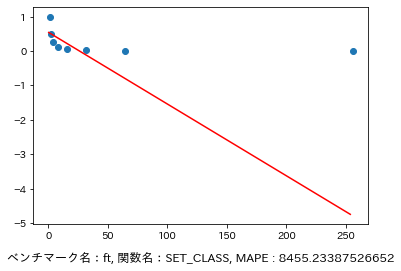

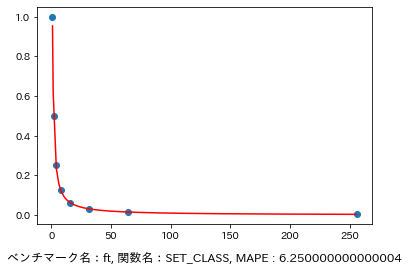

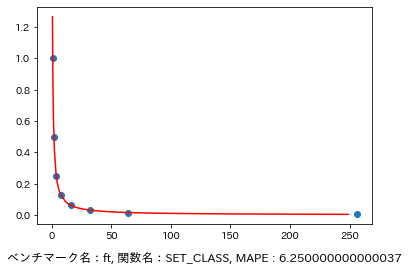

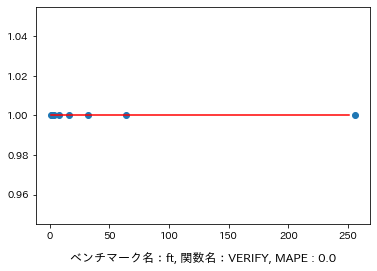

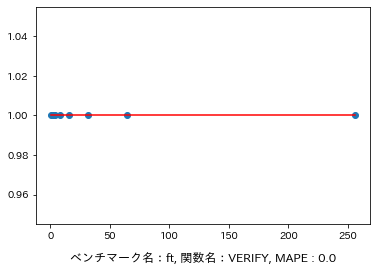

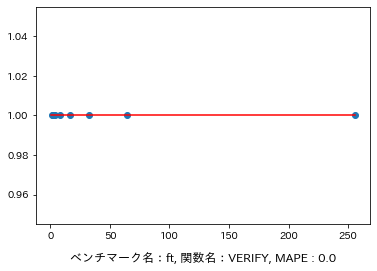

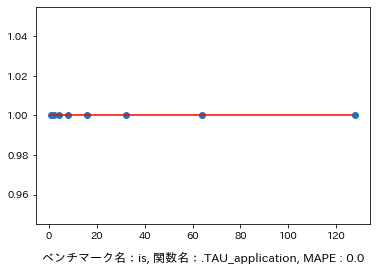

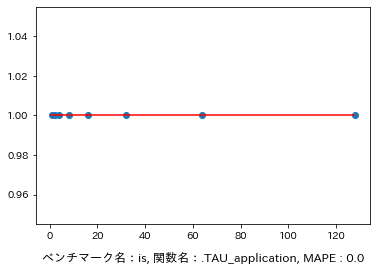

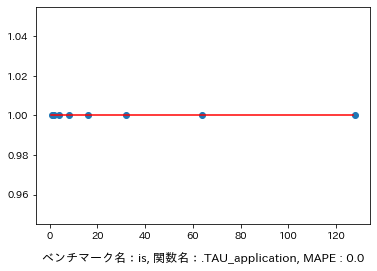

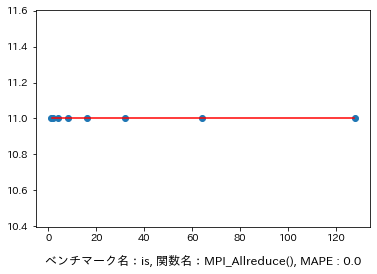

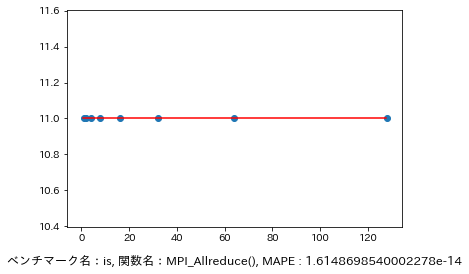

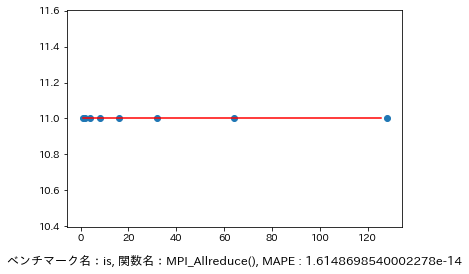

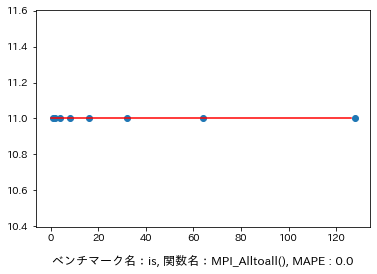

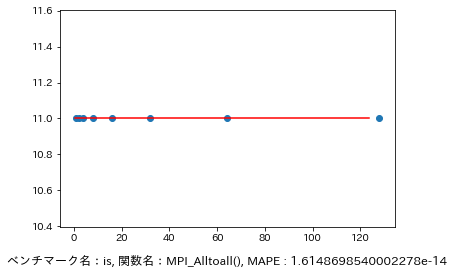

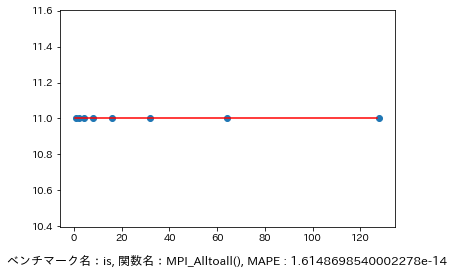

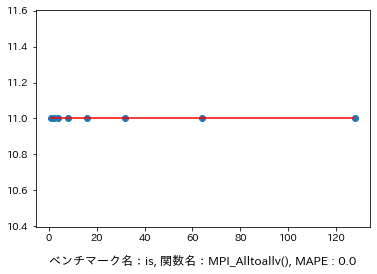

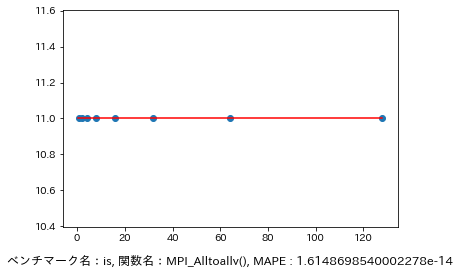

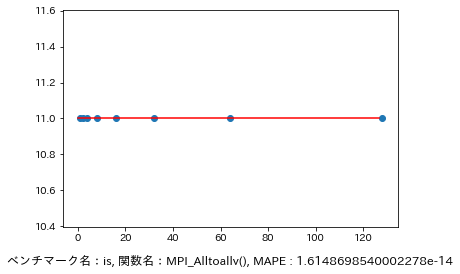

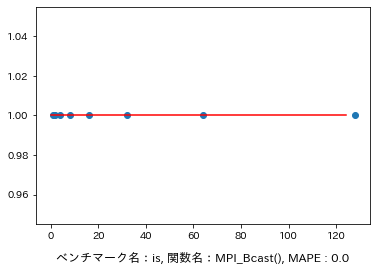

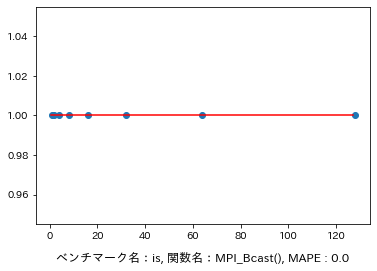

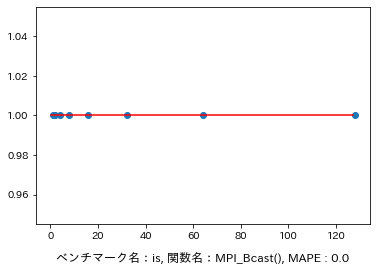

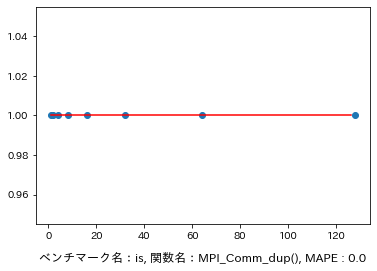

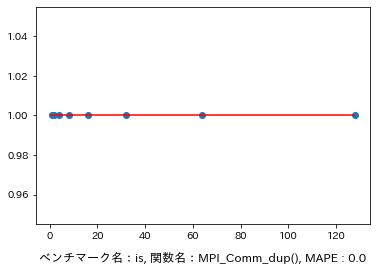

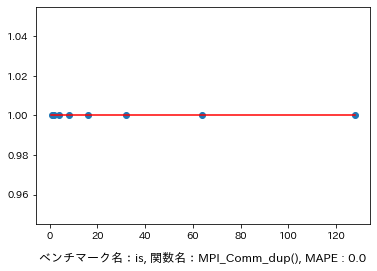

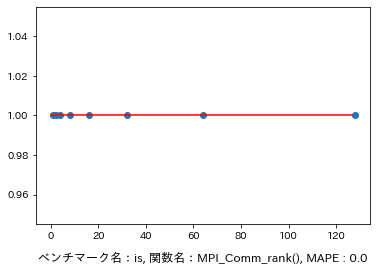

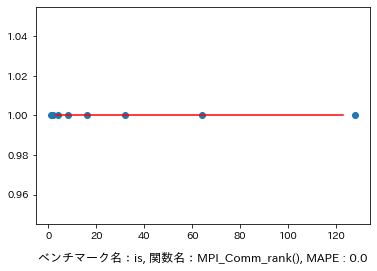

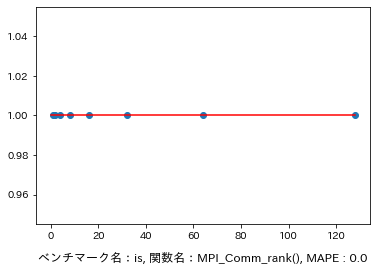

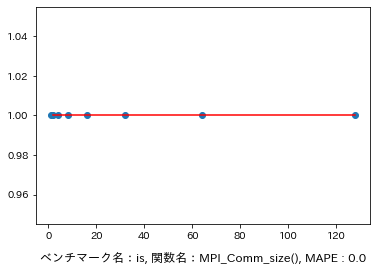

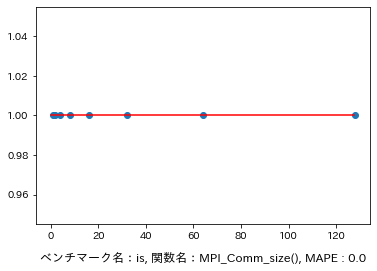

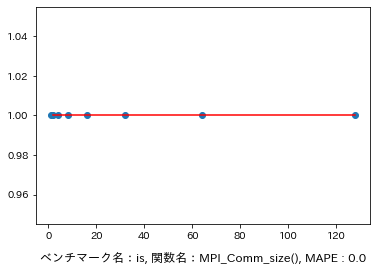

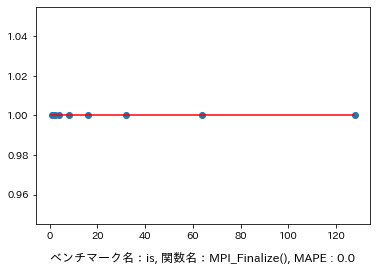

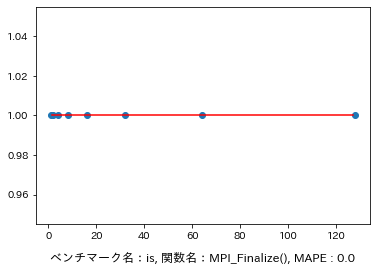

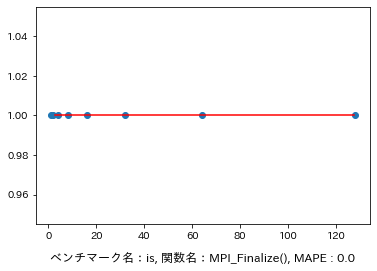

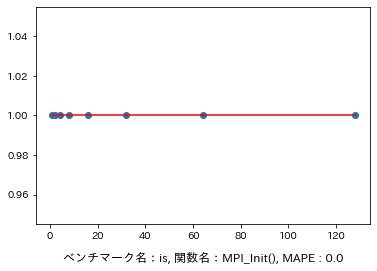

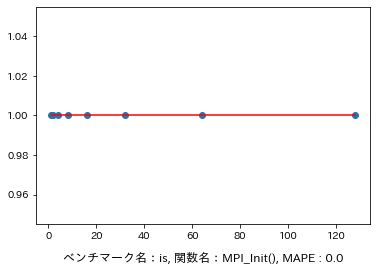

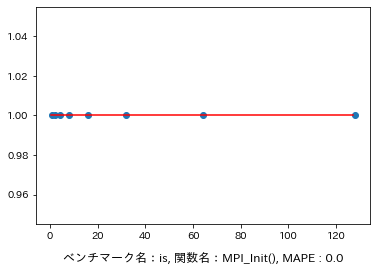

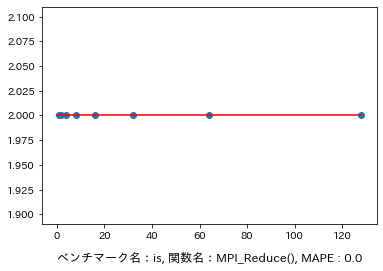

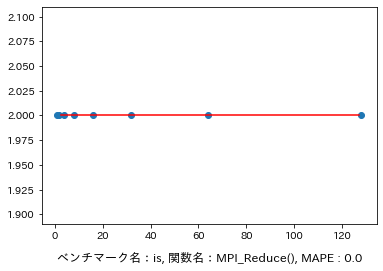

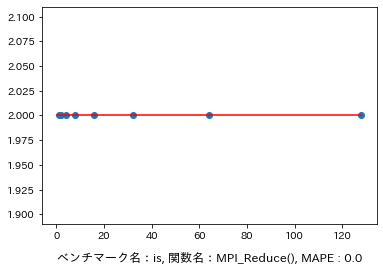

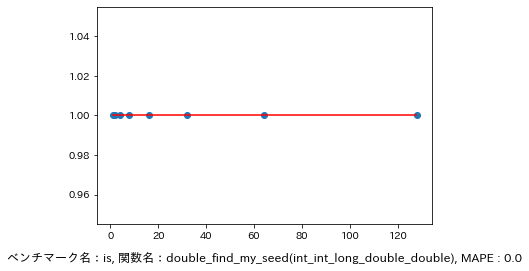

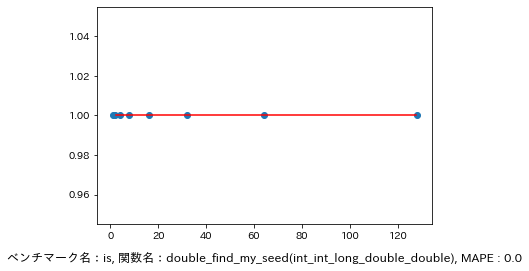

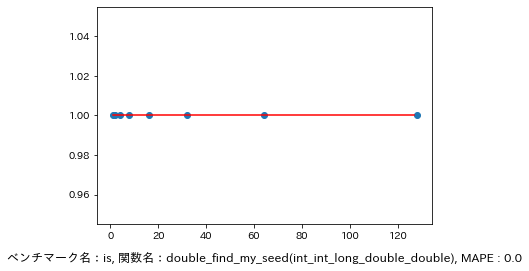

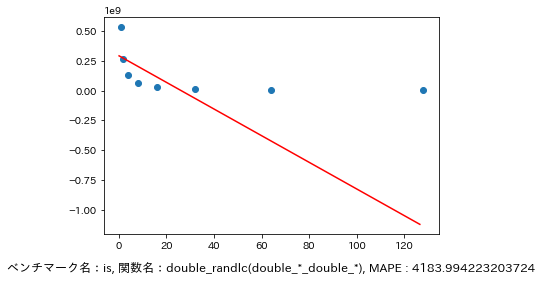

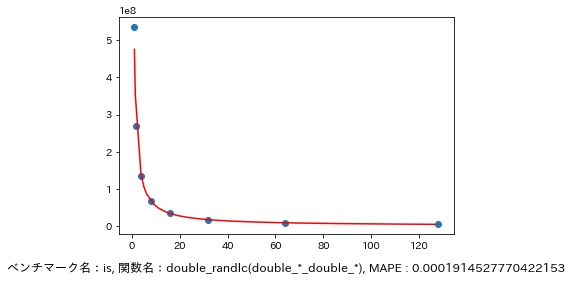

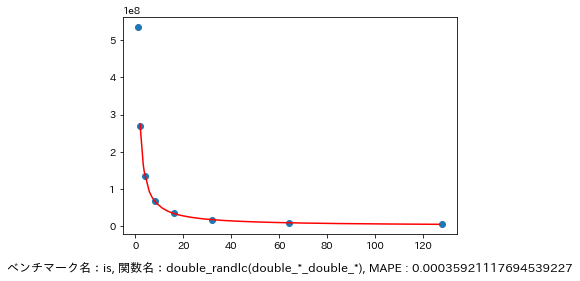

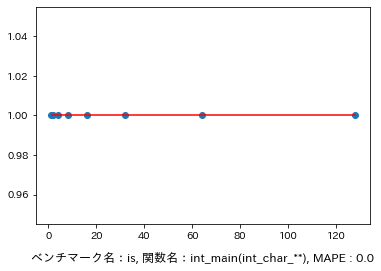

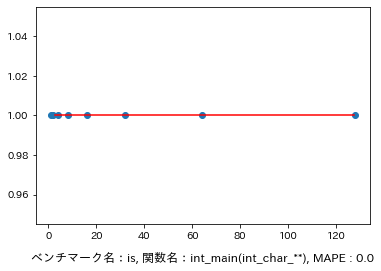

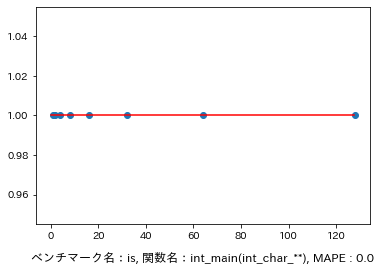

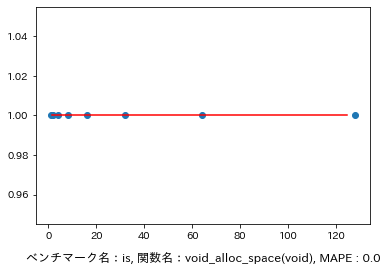

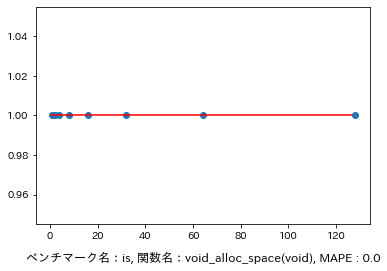

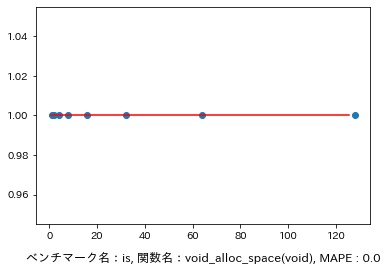

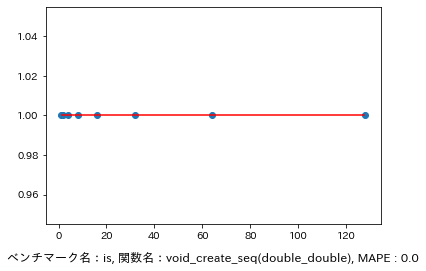

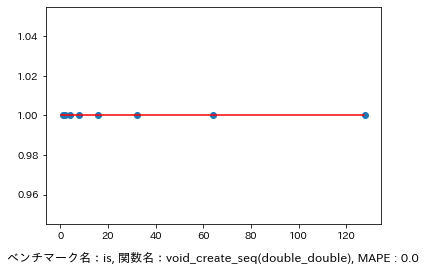

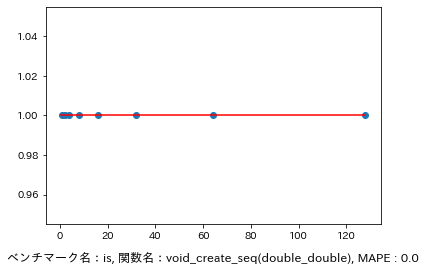

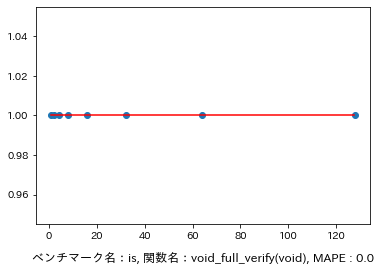

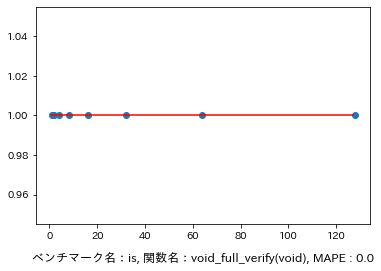

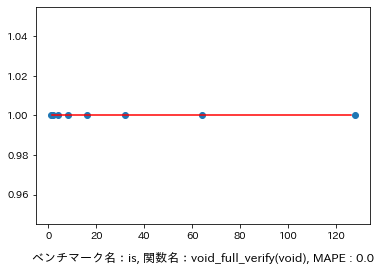

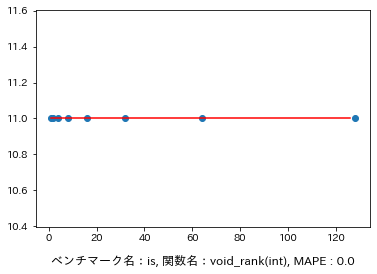

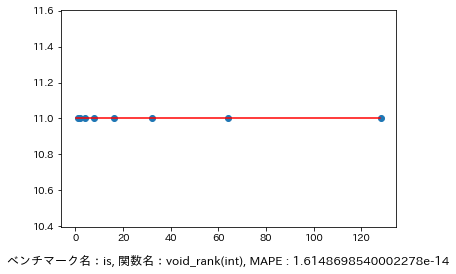

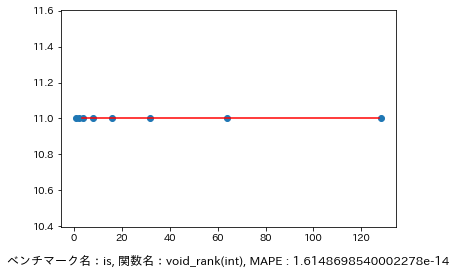

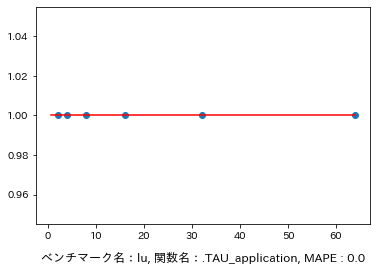

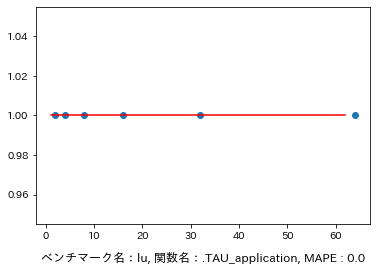

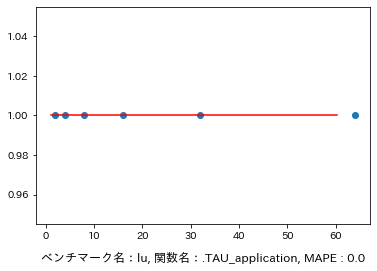

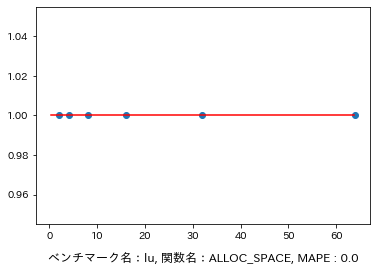

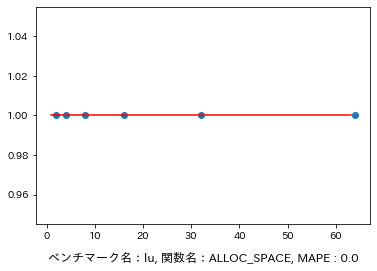

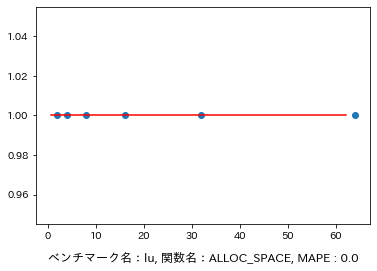

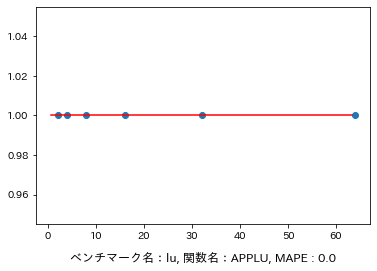

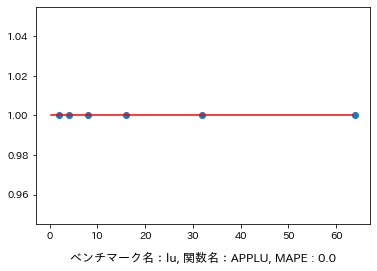

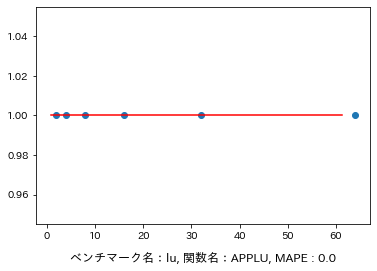

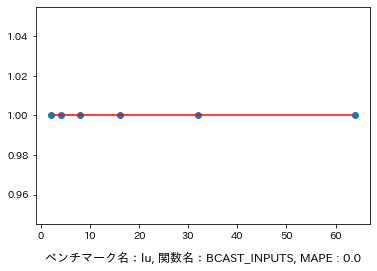

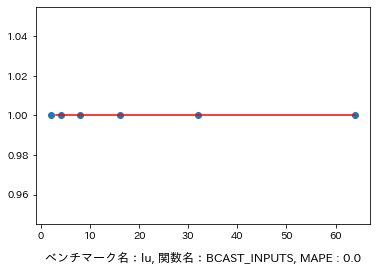

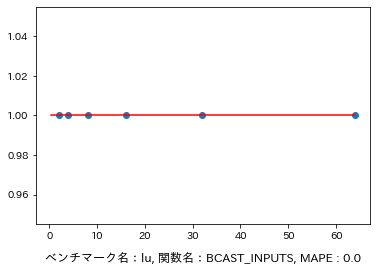

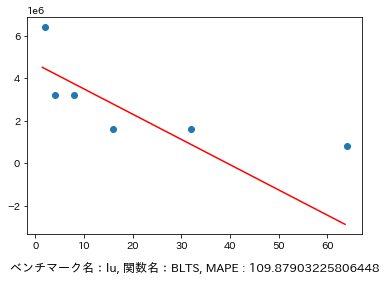

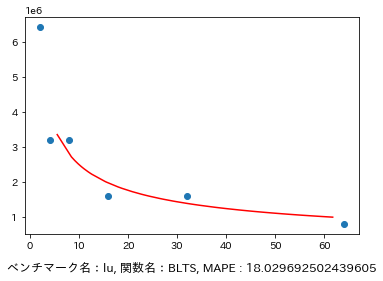

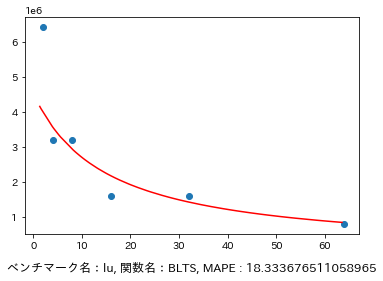

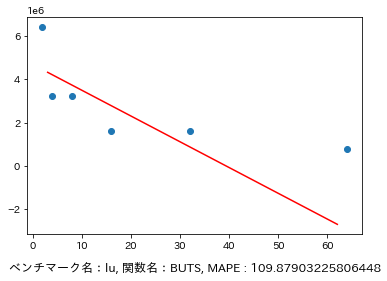

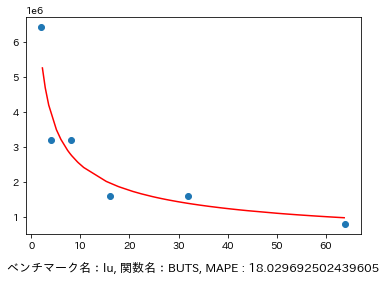

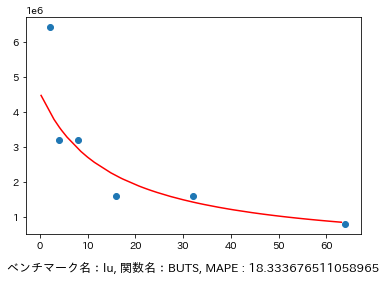

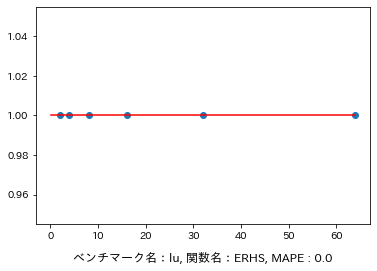

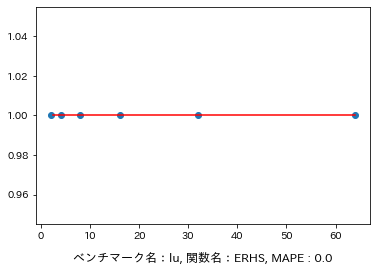

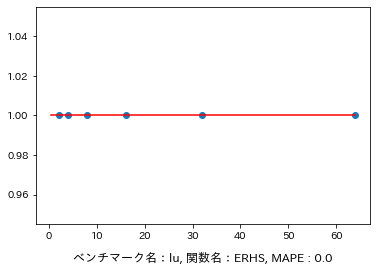

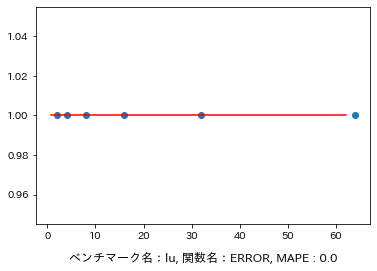

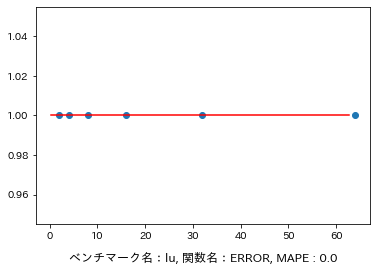

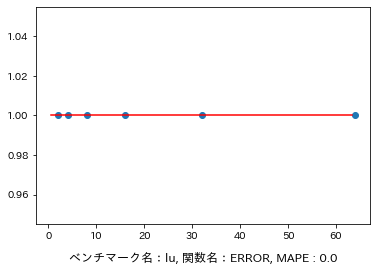

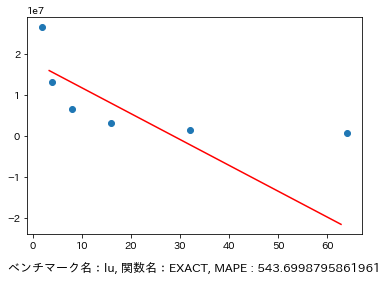

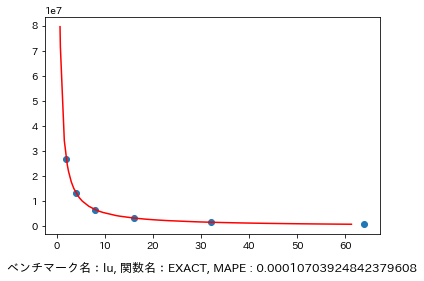

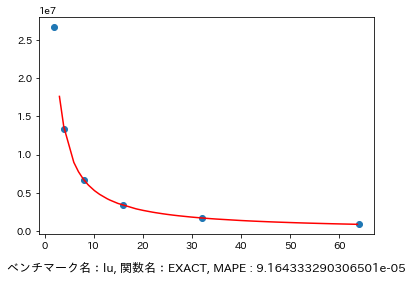

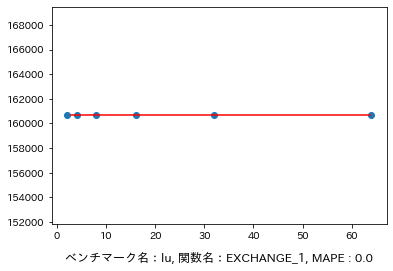

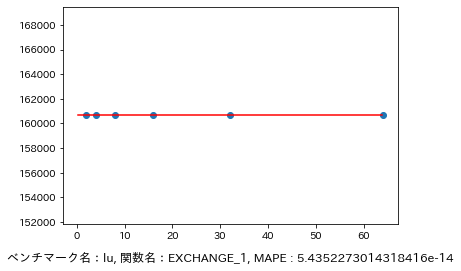

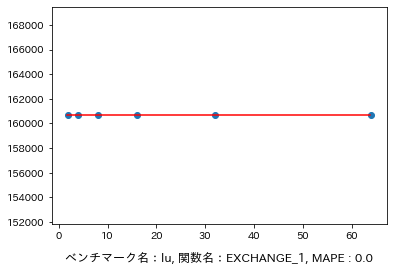

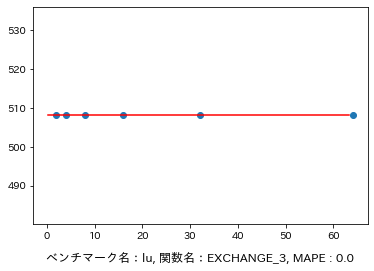

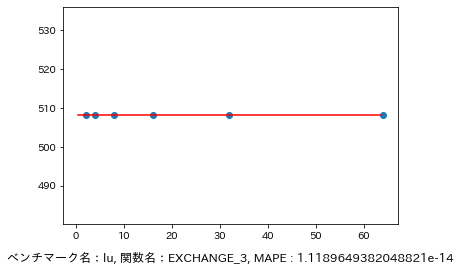

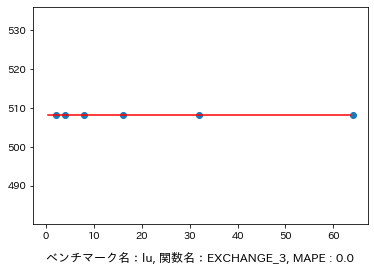

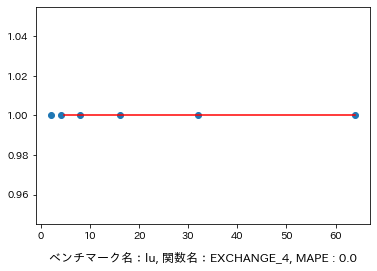

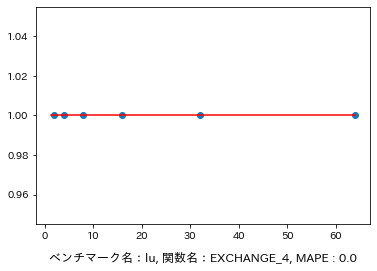

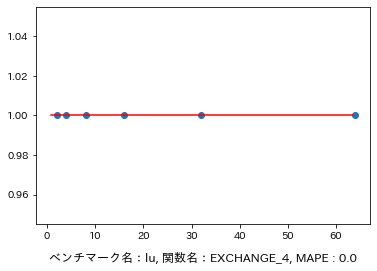

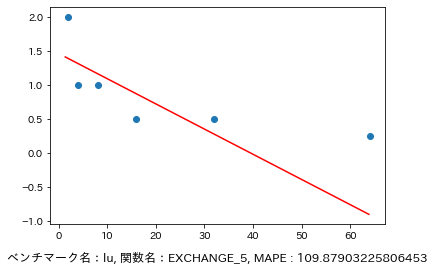

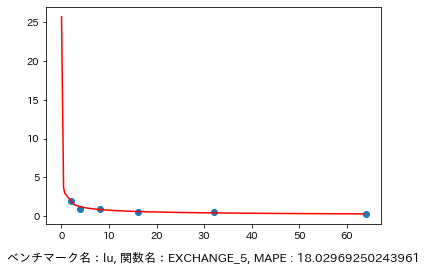

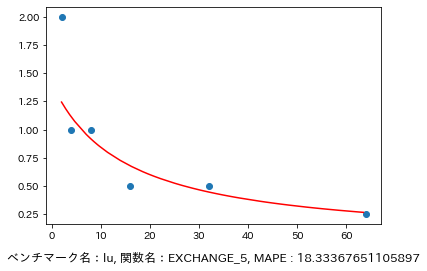

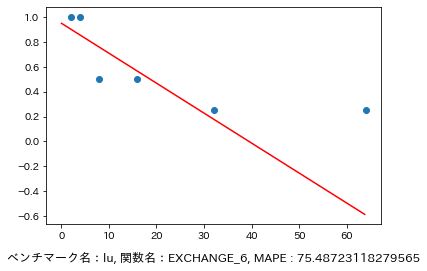

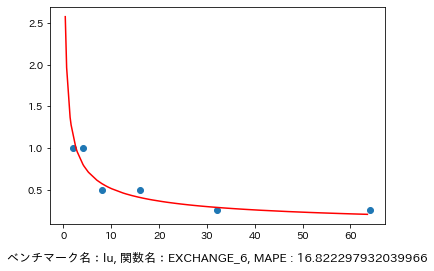

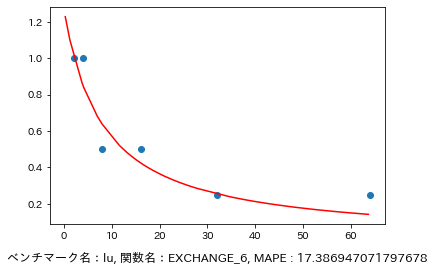

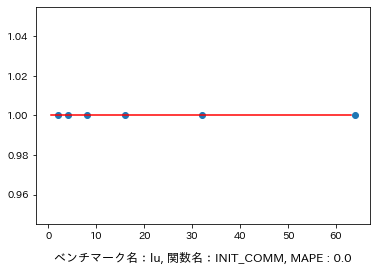

In [ ]:
for benchmark in benchmarks:
    generateScoreTable(benchmark)